In [73]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cmasher as cmr # for color maps

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [74]:
with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']


In [75]:
# Output path
OUTPUT_PATH = postprocess['output_path']

# Input path
INPUT_PATH_S = postprocess['input_path_s']
INPUT_PATH_D = postprocess['input_path_d']

In [76]:
# Select the Date
DATE = 20230402

csv_files = [f for f in os.listdir(INPUT_PATH_S) if str(DATE) in f and f.endswith('_ts.csv')]

combinded_df = pd.DataFrame()

for csv_file in csv_files:
    file_path = os.path.join(INPUT_PATH_S, csv_file)
    df = pd.read_csv(file_path)
    # Delete all spaces in column names
    df.columns = df.columns.str.replace(' ', '')
    df.set_index(['t'], inplace=True)
    combinded_df = pd.concat([combinded_df, df], axis=1)


# Show Head
combinded_df.head()

,Scenario1.GAS_PRICE,Scenario1.POWER_PRICE,Scenario1.HEAT_PRICE,Scenario1.heat_demand,Scenario1.heat_demand_scenario,Scenario1.delta_heat_demand,Scenario1.probability,Scenario1.chp1.bin,Scenario1.chp1.power,Scenario1.chp1.gas,...,Scenario3.heat_grid.heat_feedin,Scenario3.heat_grid.dispatch_heat_feedin,Scenario3.arc01_expanded.power,Scenario3.arc02_expanded.power,Scenario3.arc03_expanded.heat,Scenario3.arc04_expanded.heat,Scenario3.arc05_expanded.heat,Scenario3.arc06_expanded.gas,Scenario3.arc07_expanded.gas,Scenario3.arc08_expanded.heat
t,,,,,,,,,,,,,,,,,,,,,
1,0.1543,0.105,0.05,86.890206,95.603193,-8.712988,0.950546,0.0,0.0,0.0,...,174.000000,12.731658,0.0,0.000000,0.0,0.000000,174.0,162.464986,0.0,0.00000
2,0.1543,0.105,0.05,102.670129,93.952427,8.717702,0.950546,0.0,0.0,0.0,...,254.589826,-13.386146,0.0,47.608072,0.0,80.589826,174.0,162.464986,0.0,0.00000
3,0.1543,0.105,0.05,197.108180,235.736272,-38.628091,0.950546,0.0,0.0,0.0,...,197.108180,-107.306167,0.0,0.000000,0.0,0.000000,174.0,162.464986,0.0,23.10818
4,0.1543,0.105,0.05,131.411104,120.191749,11.219356,0.950546,0.0,0.0,0.0,...,174.000000,-19.548737,0.0,0.000000,0.0,0.000000,174.0,162.464986,0.0,0.00000
5,0.1543,0.105,0.05,134.362787,139.024750,-4.661963,0.950546,0.0,0.0,0.0,...,174.000000,-4.661963,0.0,0.000000,0.0,0.000000,174.0,162.464986,0.0,0.00000


In [77]:
combinded_df.columns.tolist()

['Scenario1.GAS_PRICE',
 'Scenario1.POWER_PRICE',
 'Scenario1.HEAT_PRICE',
 'Scenario1.heat_demand',
 'Scenario1.heat_demand_scenario',
 'Scenario1.delta_heat_demand',
 'Scenario1.probability',
 'Scenario1.chp1.bin',
 'Scenario1.chp1.power',
 'Scenario1.chp1.gas',
 'Scenario1.chp1.heat',
 'Scenario1.chp1.eta_th',
 'Scenario1.chp1.eta_el',
 'Scenario1.chp1.y1',
 'Scenario1.chp1.y2',
 'Scenario1.chp2.bin',
 'Scenario1.chp2.power',
 'Scenario1.chp2.gas',
 'Scenario1.chp2.heat',
 'Scenario1.chp2.eta_th',
 'Scenario1.chp2.eta_el',
 'Scenario1.chp2.y1',
 'Scenario1.chp2.y2',
 'Scenario1.boiler1.bin',
 'Scenario1.boiler1.heat',
 'Scenario1.boiler1.gas',
 'Scenario1.boiler1.eta_th',
 'Scenario1.boiler1.y1',
 'Scenario1.boiler1.y2',
 'Scenario1.heat_storage1.heat_charge',
 'Scenario1.heat_storage1.bin_charge',
 'Scenario1.heat_storage1.heat_discharge',
 'Scenario1.heat_storage1.bin_discharge',
 'Scenario1.heat_storage1.heat_balance',
 'Scenario1.heat_storage1.heat_capacity',
 'Scenario1.heat_st

In [78]:
fontsize_label = 16
fontsize_ticks = 14
fontsize_title = 18

# Function to set axis properties
def set_axis_properties(ax, title, ylabel, xlabel, fontsize_title, fontsize_label):
    ax.grid()
    ax.set_title(title, fontsize=fontsize_title)
    ax.set_ylabel(ylabel, fontsize=fontsize_label)
    ax.set_xlabel(xlabel, fontsize=fontsize_label)
    ax.legend(loc='center left', fontsize=fontsize_ticks)
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels(range(0, 25, 4))
    ax.set_xlim([0, 24])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)


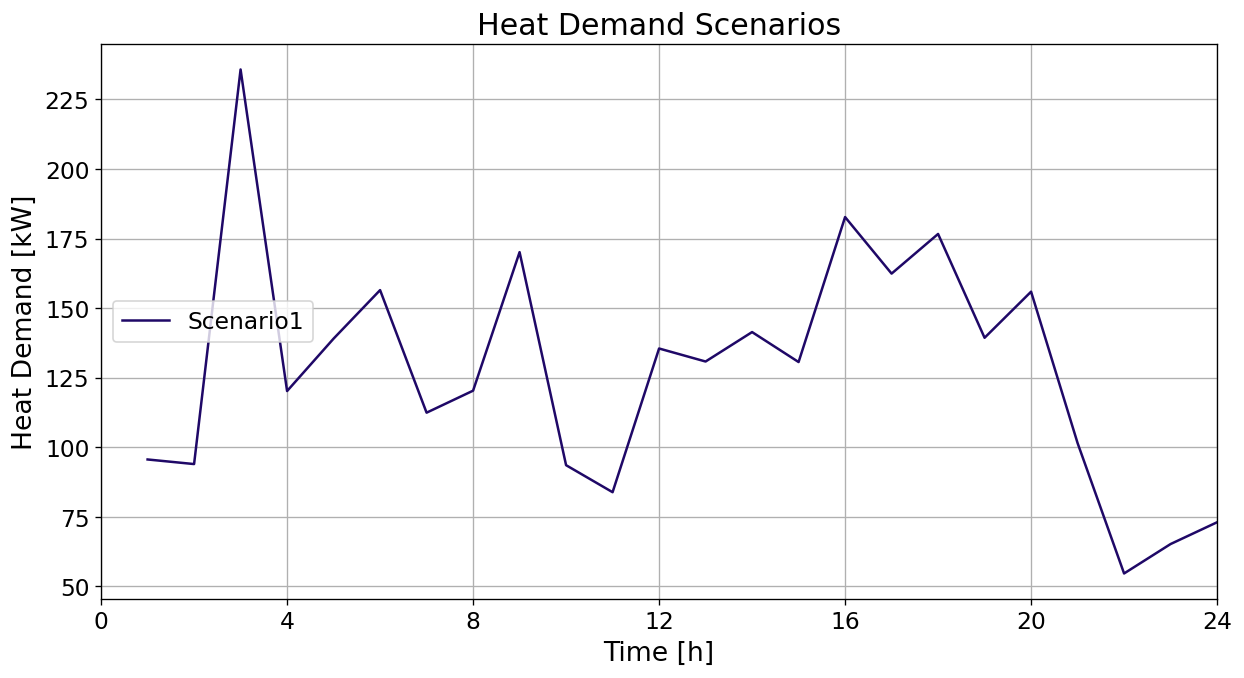

In [85]:
#scenarios_to_plot = ['Scenario1.heat_demand_scenario', 'Scenario2.heat_demand_scenario', 'Scenario3.heat_demand_scenario']

scenarios_to_plot = ['Scenario1.heat_demand_scenario']

data_to_plot = [combinded_df[scenario] for scenario in scenarios_to_plot]
labels = [scenario.split('.')[0] for scenario in scenarios_to_plot]

# Set Colors
colors = cmr.take_cmap_colors('cmr.chroma', N=len(data_to_plot), cmap_range=(0.15, 0.85))

# Create the plot

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

for i, data in enumerate(data_to_plot):
    ax.plot(data.index, data, label=labels[i], color=colors[i])

# Set Axis Properties
set_axis_properties(ax, 'Heat Demand Scenarios', 'Heat Demand [kW]', 'Time [h]', fontsize_title, fontsize_label)